In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook

In [2]:
import os 
import yank.analyze as yank
from yank.reports import notebook
import matplotlib as mt
from matplotlib import pyplot as plt
from matplotlib import pylab
from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.datasets.samples_generator import make_blobs
from sklearn.preprocessing import StandardScaler
import pandas as pnd
import numpy as np
import mdtraj as md
import nglview as nv

In [3]:
# Matplotlib options
%matplotlib inline
mt.style.use('ggplot')
pylab.rcParams['figure.figsize'] = 12, 8

# Set the path for your experiment
Path is the direcrtory where the file analysis.yaml and complex.nc files are located.

In [4]:
os.chdir ('/DATA/projects/Testing_Yank/results_paper/p-xylene-implicit-output/experiments/')

# Number of states 

In [5]:
store_directory = '/DATA/projects/Testing_Yank/results_paper/p-xylene-implicit-output/experiments/'
report = notebook.HealthReportData(store_directory)
report.general_simulation_data()

  Phase  | Iterations | States | Num Atoms 
 complex |   15001    |   28   |   2621    
-------------------------------------------
 solvent |   15001    |   21   |    18     
-------------------------------------------


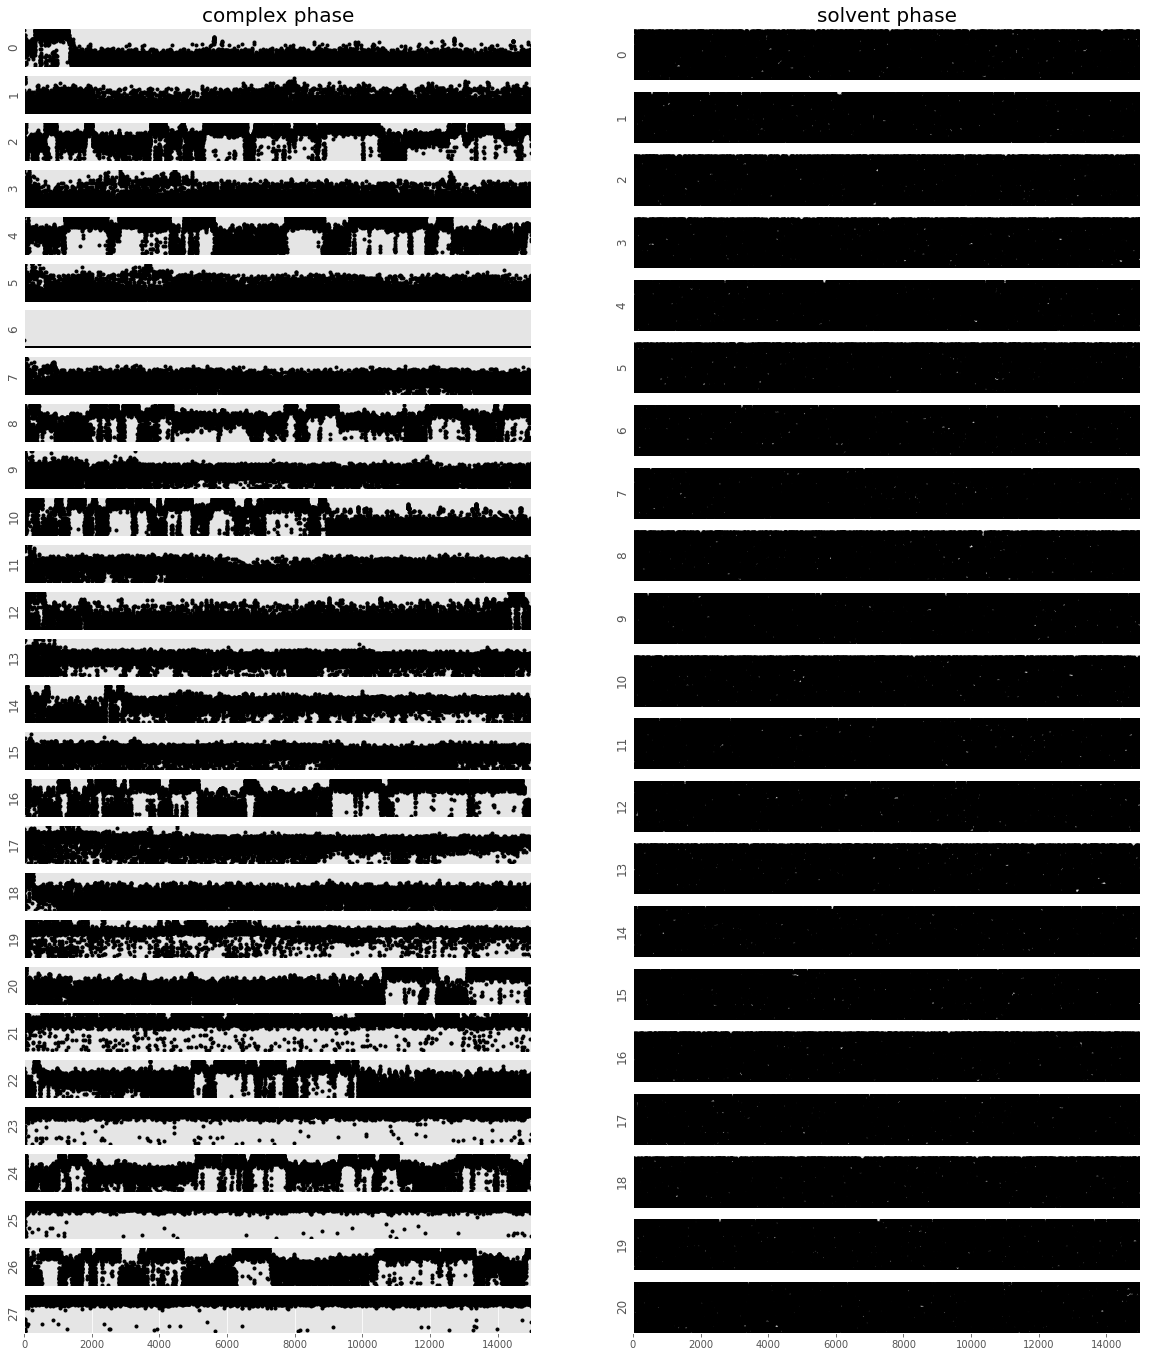

In [6]:
phase_stacked_replica_plots = False
replica_mixing_figure = report.generate_replica_mixing_plot(phase_stacked_replica_plots=phase_stacked_replica_plots)

# Save HDF5 trajectories for each replica
Comment this part of the script once you saved your trajectories if you pretend to restart the kernel. Save trajectory files usually takes several time (depending on the number of the interations of your simulation). Be patient!

n_replica= np.arange (3,28) #Replace this number with the total of replicas you have in your experiment
for i in n_replica:
    index=str(i)
    save_file= ('replica_trajectories/'+'replica_'+index+'.h5') #this line needs a replica_trajectories folder in 'experiments' path
    result= yank.extract_trajectory ('complex.nc',nc_checkpoint_file='complex_checkpoint.nc', replica_index=index, start_frame=0, end_frame=-1, keep_solvent=False)
    result.save_hdf5 (save_file) #save in hdf5 format, but it can be replaced by other format depending on your interest, you can check mdtraj manual for more information

# Set the path for replica trajectory files
This folder is the location where you saved the trajectories of the replicas of your simulation.

In [7]:
os.chdir ('/DATA/projects/Testing_Yank/results_paper/p-xylene-implicit-output/experiments/replica_trajectories/')

# Select a replica to visualize

In [8]:
n_replica= np.arange (3)
for i in n_replica:
    index=str(input('Insert a replica number, is a int from 0 to 27:'))
    if isinstance (index, str):
            replica=('replica_'+index+'.h5')
            load_replica= md.load_hdf5 (replica)
            print ('Showing_Replica:',index)
            break
    else: 
            print ('This is not a valid replica number, try another')
            
view= nv.show_mdtraj (load_replica) #Shows the selected replica
view.clear_representations ()
view.add_ball_and_stick (selection='MOL', color='red', aspectRatio='10')
view.add_cartoon (selection="protein")
view

Insert a replica number, is a int from 0 to 27:5
Showing_Replica: 5


NGLWidget(count=15000)

# Load all replicas as new variables for analysis

In [9]:
traj={} #dictionary to create each centered replica as variable
n_replica= np.arange (28)
for i in n_replica:
    index=str(i)
    file_name=('replica_'+index+'.h5')
    load=md.load_hdf5 (file_name)
    center=md.Trajectory.center_coordinates (load)
    trayectories=traj['{0}'.format(i)]= center.superpose (center, frame=0)

# Analysis from paper

1. Wang K, Chodera JD, Yang Y, Shirts MR. Identifying ligand binding sites and poses using GPU-accelerated Hamiltonian replica exchange molecular dynamics. J Comput Aided Mol Des. 2013;27: 989–1007. doi:10.1007/s10822-013-9689-8

## Binding site identification: 

The configurations sampled at all of the fully coupled (i.e., fully interacting) states were analyzed together to give final predictions of putative binding sites. In the analysis, the location of the ligand for any given configuration was determined by the ligand atom closest to the center of geometry of the ligand.

Fully interacting states (lambda = 1): Replica 0 to 6

### Defining a new variable for ligand in fully interacting replicas

In [10]:
p_xylene={} #dictionary to create p-xylene trayectories for replica
ligand=np.arange (2603,2621)
n_replica= np.arange (7)
for i in n_replica:
    index=str(i)
    load=('replica_'+index+'.h5')
    trayectories=p_xylene['{0}'.format(i)]= md.load_hdf5 (load, atom_indices=ligand)

### Calculating the centroid for ligand

In [11]:
### write the lines for centroid calculation

## Protein alignment: 

Both the protein and ligand were flexible during simulations. To be able to cluster all ligand binding sites, all protein conformations from all complexes had to be aligned to provide information on ligand locations relative to the protein. Alignments used the Kabsch algorithm (RMSD). All configurations were aligned to the alpha carbons of the crystal structure.

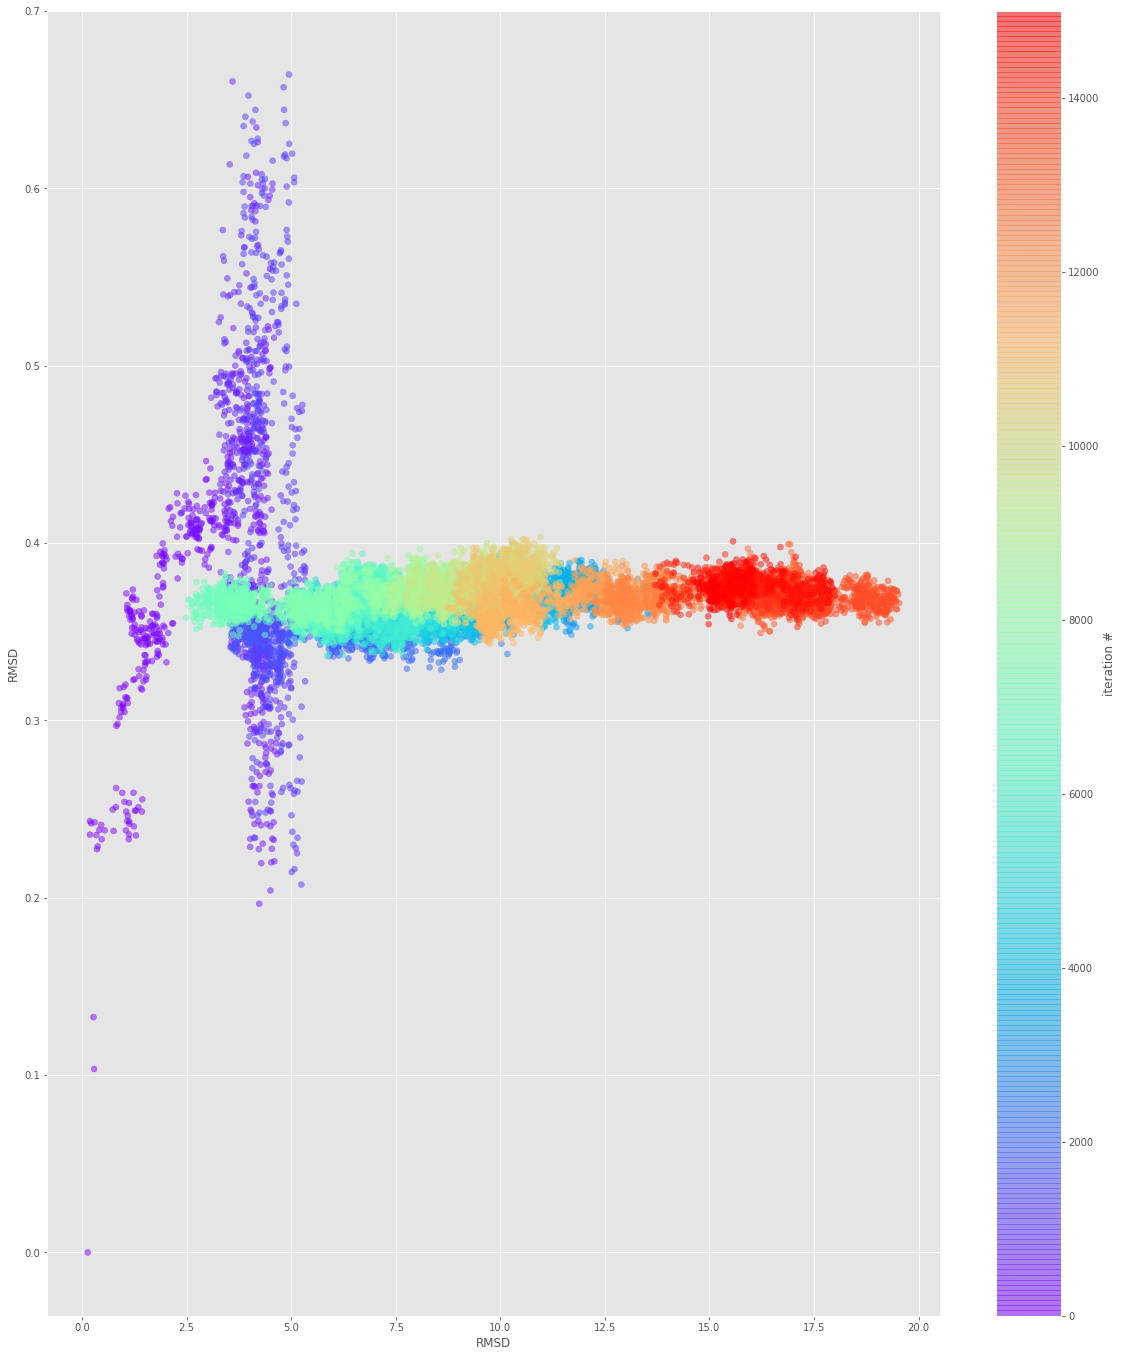

In [12]:
rmsd_0=md.rmsd (traj['0'],reference=traj['0'], frame=0) 
replicas=np.arange (0,7)
for replica in replicas:
    index=str(replica)
    rmsd=md.rmsd (traj[index],reference=traj['0'], frame=0) 
        
import warnings
warnings.filterwarnings('ignore')

plt.figure()
plt.scatter(rmsd, rmsd_0, marker='o', c=range(traj['0'].n_frames), alpha=0.5,cmap='rainbow')
plt.xlabel('RMSD')
plt.ylabel('RMSD')
cbar = plt.colorbar()
cbar.set_label('iteration #')

## Ligand alignment

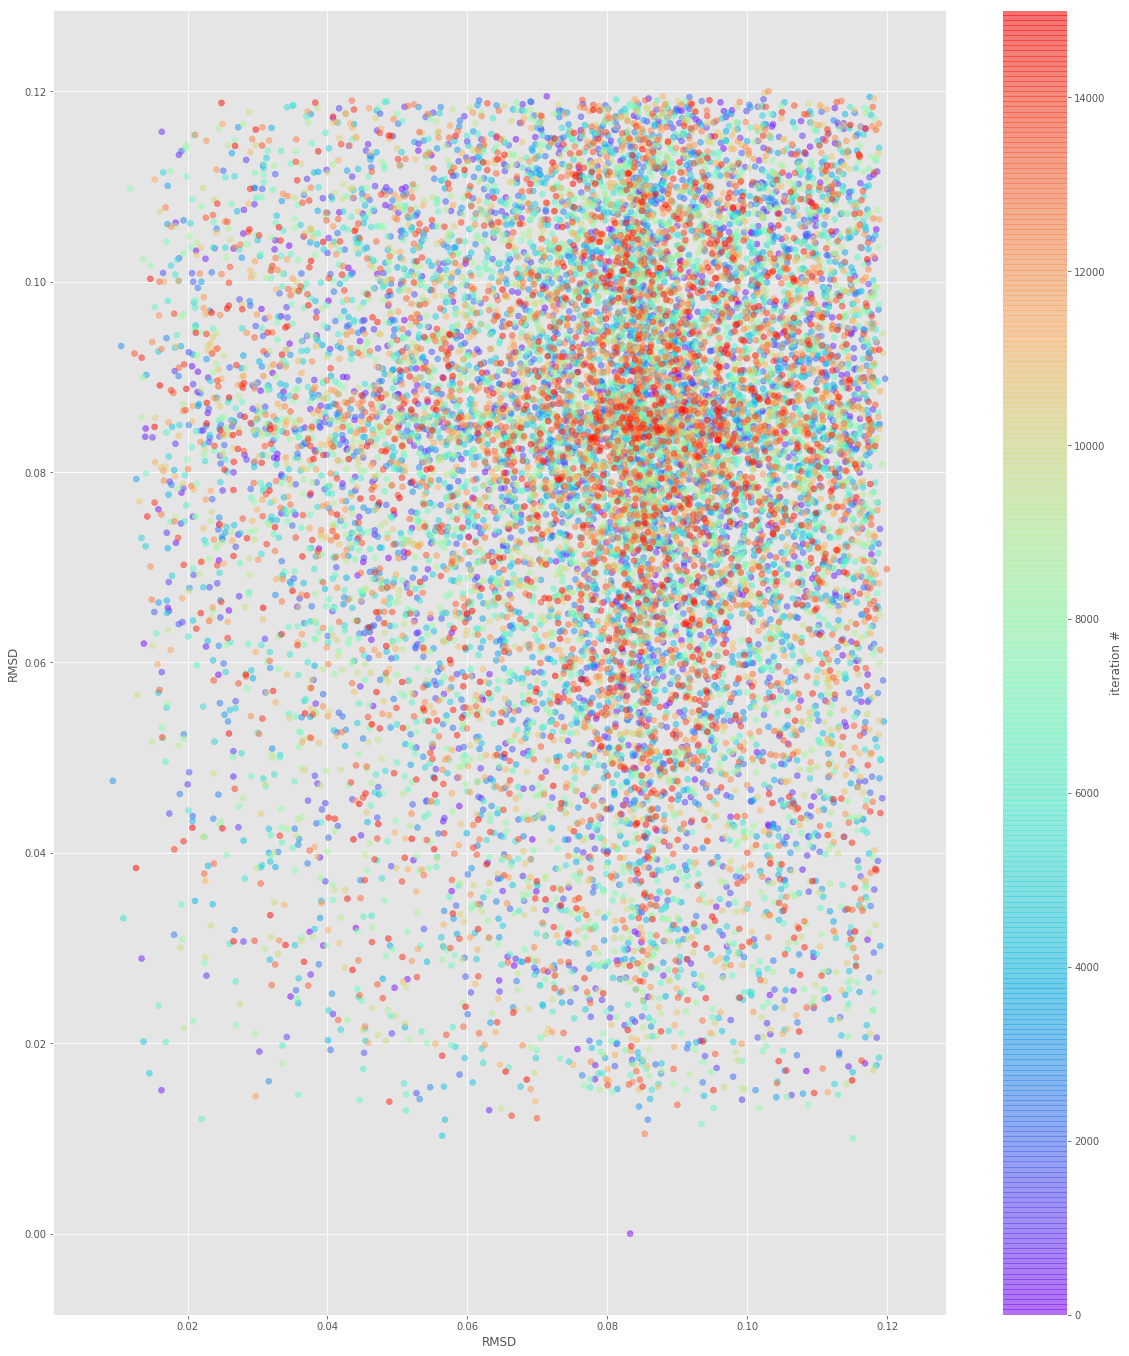

In [13]:
rmsd_0=md.rmsd (p_xylene['0'],reference=p_xylene['0'], frame=0) 
replicas=np.arange (0,7)
for replica in replicas:
    index=str(replica)
    rmsd=md.rmsd (p_xylene[index],reference=p_xylene['0'], frame=0) 
        
import warnings
warnings.filterwarnings('ignore')

plt.figure()
plt.scatter(rmsd, rmsd_0, marker='o', c=range(traj['0'].n_frames), alpha=0.5,cmap='rainbow')
plt.xlabel('RMSD')
plt.ylabel('RMSD')
cbar = plt.colorbar()
cbar.set_label('iteration #')

In [27]:
com_0=md.compute_center_of_mass (p_xylene['0'])
replicas=np.arange (0,7)
for replica in replicas:
    index=str(replica)
    center_of_mass=md.compute_center_of_mass (p_xylene[index])

AttributeError: 'numpy.ndarray' object has no attribute 'n_frames'

Text(0,0.5,'Center of Mass')

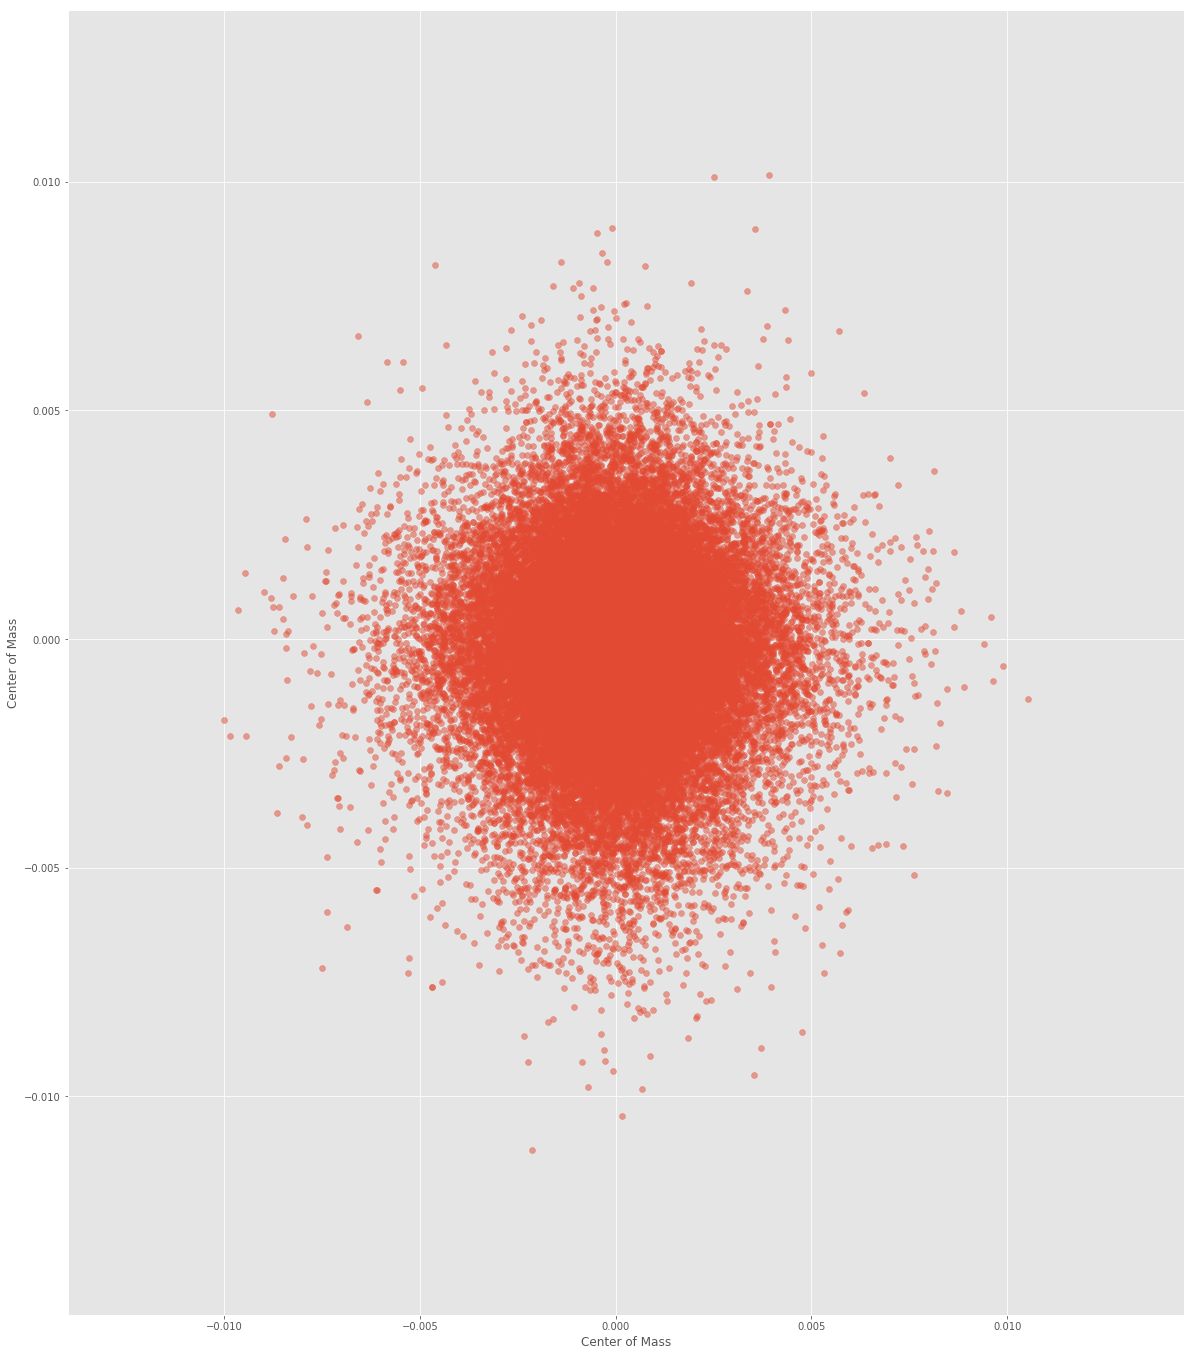

In [23]:
import warnings
warnings.filterwarnings('ignore')

plt.figure()
plt.scatter(com, com_0, marker='o', alpha=0.5, cmap='rainbow')
plt.xlabel('Center of Mass')
plt.ylabel('Center of Mass')
#cbar = plt.colorbar()
#cbar.set_label('iteration #')

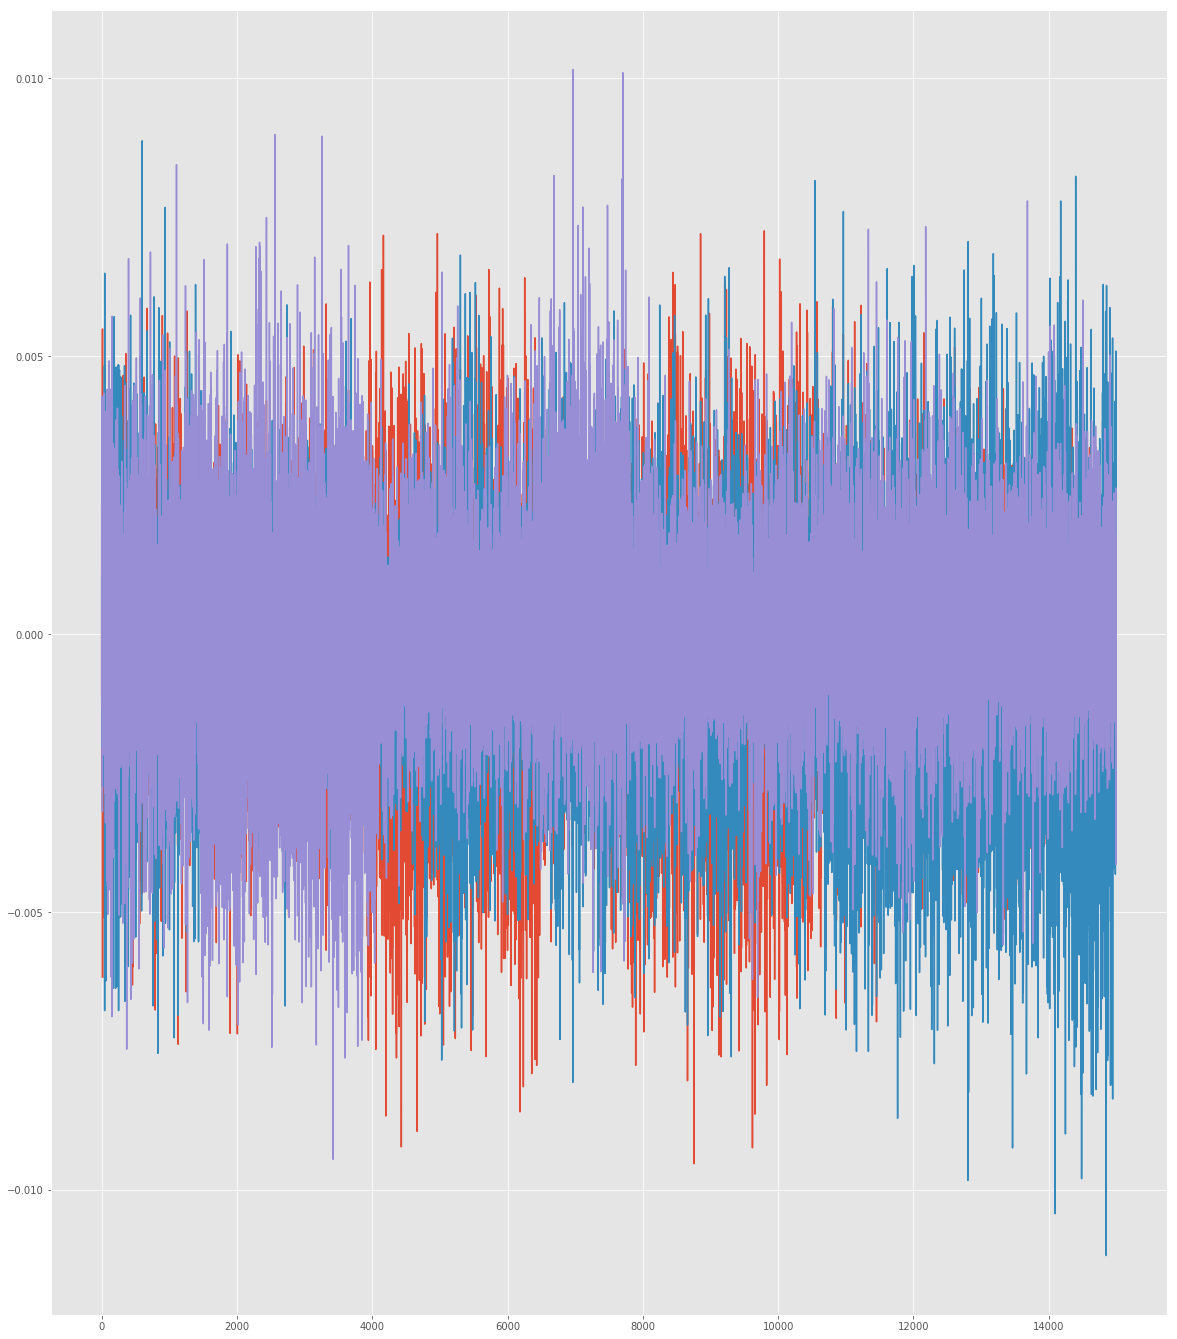